# 101 Course of transfer learning and Fine tune 2021-01-01

## Train a pre-train Weights for K-Fold trainer.

todo: move to note.py


In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer

In [2]:
print(tf.__version__)
print(cv2.__version__)

2.3.1
4.3.0


### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [3]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [4]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [5]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [6]:

# # data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'



# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# df[1335:]


# data-train #
ann = 'annotation_1345_good.csv'
im_p = 'train/images/'

# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'

# # data-train-HPL-1223
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'

df = pd.read_csv(ann)
df[1120:]

,images,x1,y1,x2,y2
1120,image_6195.jpg,52,127,75,370
1121,image_6196.jpg,62,138,29,383
1122,image_6197.jpg,54,135,78,380
1123,image_6198.jpg,60,125,29,384
1124,image_6199.jpg,51,147,70,353
...,...,...,...,...,...
1340,image_6419.jpg,60,135,70,381
1341,image_6421.jpg,53,157,76,376
1342,image_6422.jpg,49,154,33,375
1343,image_6423.jpg,64,149,76,381


In [7]:
len(df)

1345

#### Shuffle and reset index

In [8]:
# reset index
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
df.head(10)

,images,x1,y1,x2,y2
0,image_0683.png,49,125,44,366
1,image_0425.png,62,136,75,382
2,image_6408.jpg,65,139,41,375
3,image_0992.png,49,141,77,382
4,image_0126.png,58,145,29,381
5,image_0336.png,63,132,27,382
6,image_0936.png,58,104,76,382
7,image_0853.png,62,122,31,369
8,image_0509.png,52,147,79,383
9,image_0710.png,56,146,76,383


See, the image_####.jpg now are random.

#### Create tf.dataset (DS)

In [10]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [11]:
len(list_ds)#.shape() #take(1)

1345

In [12]:
# check The type specification of an element of this dataset.
list_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [13]:
for f,x1,y1,x2,y2 in list_ds.take(5):
    print(f'take sample: {f} {x1} {y1} {x2} {y2}')

take sample: b'image_0683.png' 49 125 44 366
take sample: b'image_0425.png' 62 136 75 382
take sample: b'image_6408.jpg' 65 139 41 375
take sample: b'image_0992.png' 49 141 77 382
take sample: b'image_0126.png' 58 145 29 381


In [14]:
# use np decode to UTF-8
print(f.numpy().decode('UTF-8'))

image_0126.png


In [15]:
len(list_ds)

1345

#### Check ds iterator for consuming

In [16]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [17]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image, x1, y1, x2, y2 = next(it_list_ds)
    print(image.numpy(), x1.numpy(), y1.numpy())

b'image_0683.png' 49 125
b'image_0425.png' 62 136
b'image_6408.jpg' 65 139
b'image_0992.png' 49 141


In [18]:
# image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)


for i in range(4):
    image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
    print(image, x1, y1, x2, y2)
    
iter_test_list = list_ds.as_numpy_iterator()
print("===== Create iterator once and pull out to above cell. =====")
for i in range(4):
    image, x1, y1, x2, y2 = iter_test_list.next()
    print(image, x1, y1, x2, y2)


b'image_0683.png' 49 125 44 366
b'image_0683.png' 49 125 44 366
b'image_0683.png' 49 125 44 366
b'image_0683.png' 49 125 44 366
===== Create iterator once and pull out to above cell. =====
b'image_0683.png' 49 125 44 366
b'image_0425.png' 62 136 75 382
b'image_6408.jpg' 65 139 41 375
b'image_0992.png' 49 141 77 382


#### Process path to image tensor in DS

In [19]:

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [20]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [21]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

for img, [x, y] in train_ds_map_toe.take(1):
    print(f'take sample: {x} {y}')
    
print('f', f.dtype)
print('x', x.dtype)

take sample: 49 45
f <dtype: 'string'>
x <dtype: 'int64'>


In [22]:
x

<tf.Tensor: shape=(), dtype=int64, numpy=49>

In [23]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

In [24]:
# split Toe
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

print(len(train_ds_map_toe))
print(val_size)
print(tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
print(tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

1345
269
1076
269


In [25]:
# split Heel
val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

print(len(train_ds_map_heel))
print(val_size)
print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

1345
269
1076
269


# Albumentation pipeline

In [26]:

# # for NO keypoint augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label








# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA (alpha=0.1, always_apply=False, p=1),
            A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
            A.HorizontalFlip(p=0.5),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
            )



# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)]
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
#     print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

#     print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])
#     print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(keypoints, [2,]) # for 'tf ds tarining'
#     print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 


def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

#### prepare train_ds_prefetch

In [27]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [28]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [29]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# Toe ds_pre
train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# Heel ds_pre
train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

Check cache in memory:Y True
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]


#### Check ds_prefetch samples

In [30]:
# create it_ds once
it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
Check lables: [49 58]
Check lables: [52 59]
Check lables: [57 75]
Check lables: [52 60]
Check lables: [57 39]
Check lables: [76 52]
Check lables: [57 63]
Check lables: [67 59]
Check lables: [65 40]
Check lables: [65 51]
Check lables: [61 58]
Check lables: [51 62]
Check lables: [44 24]
Check lables: [49 57]
Check lables: [53 58]
Check lables: [61 43]
CPU times: user 6.2 s, sys: 1.08 s, total: 7.29 s
Wall time: 2.55 s


/home/u3148947/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


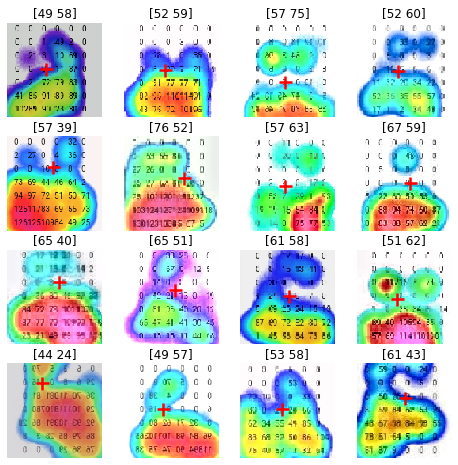

In [31]:
%%time

# for albu keypoint

# for original return aug_img, , aug_xy 


image_batch, label_batch = next(it_train_ds_pre_toe_s)

fig = plt.figure(figsize=(8, 8))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

    print(f'Check lables: {label_batch[i]}')


In [32]:
# create it_ds once
it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
Check lables: [ 89 103]
Check lables: [ 27 103]
Check lables: [40 96]
Check lables: [ 35 104]
Check lables: [ 75 102]
Check lables: [ 75 104]
Check lables: [ 24 104]
Check lables: [73 99]
Check lables: [ 84 103]
Check lables: [71 93]
Check lables: [45 88]
Check lables: [39 82]
Check lables: [ 89 104]
Check lables: [ 29 105]
Check lables: [31 89]
Check lables: [ 30 103]
CPU times: user 6 s, sys: 1.05 s, total: 7.05 s
Wall time: 2.41 s


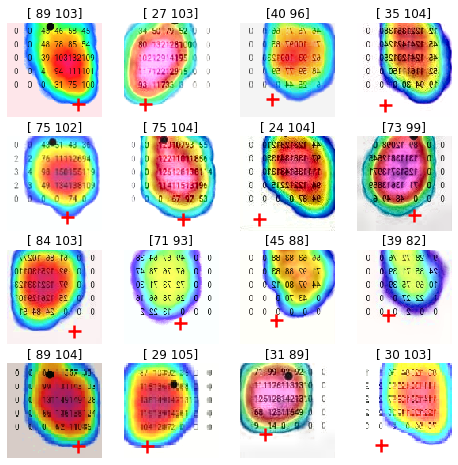

In [33]:
%%time

# for albu keypoint

# for original return aug_img, , aug_xy 


image_batch, label_batch = next(it_train_ds_pre_heel_s)

fig = plt.figure(figsize=(8, 8))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

    print(f'Check lables: {label_batch[i]}')

In [34]:
# create it_ds once
it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
Check lables: [49 45]
Check lables: [62 56]
Check lables: [65 59]
Check lables: [49 61]
Check lables: [58 65]
Check lables: [63 52]
Check lables: [58 24]
Check lables: [62 42]
Check lables: [52 67]
Check lables: [56 66]
Check lables: [57 24]
Check lables: [57 38]
Check lables: [59 47]
Check lables: [52 40]
Check lables: [61 59]
Check lables: [56 49]
CPU times: user 283 ms, sys: 18.5 ms, total: 302 ms
Wall time: 187 ms


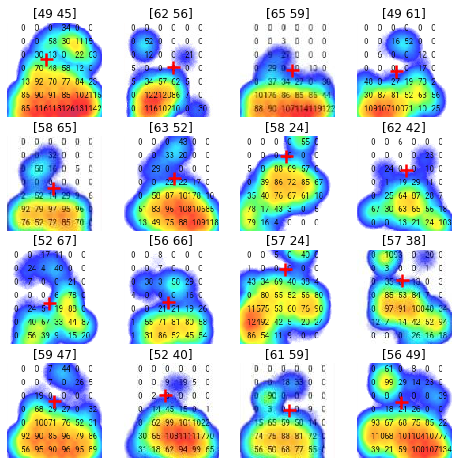

In [35]:
%%time

# for albu keypoint

# for return aug_img, aug_xy 


image_batch, label_batch = next(it_valid_ds_pre_toe_s)

plt.figure(figsize=(8, 8))
# for images, labels in valid_ds_pre_toe_s.take(1):
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

    print(f'Check lables: {label_batch[i]}')
        

In [36]:
# %%time

# #2021-01-30
# # for change default [x, y] tuple to x, y

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, x, y in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(x[i].numpy(), y[i].numpy(), 'r+', markersize=13, mew=2.5)

In [37]:
# %%time

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0], labels[i].numpy()[1], 'r+', markersize=13, mew=2.5)

In [38]:
# %%time

# # NOrmalized xy to [0, 1] #

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0]*120, labels[i].numpy()[1]*120, 'r+', markersize=13, mew=2.5)

In [39]:
# %%time

# # NOrmalized xy to [0, 1] #

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_heel_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0]*120, labels[i].numpy()[1]*120, 'r+', markersize=13, mew=2.5)

In [40]:
# %%time

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_heel_s.take(1):
#     print('batch * multi:', len(labels))
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(str(labels[i].numpy()))
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0], labels[i].numpy()[1], 'b+', markersize=13, mew=2.5)
# #         print((labels[i].numpy()[0], labels[i].numpy()[1]))

In [41]:
# create it_ds once
# it_train_ds_pre_toe = iter(train_ds_pre_toe_s)

In [42]:
# image_batch, label_batch = next(it_train_ds_pre_toe)

# plt.figure(figsize=(18, 18))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title('x1,y1:' + str(label_batch[i].numpy()))
#     plt.axis("off")
    
#     #print(label_batch[i])
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

### [OLD] Split train_ds_pre

##### train_ds_pre_s
##### valid_ds_pre_s 

### re-set to toe/heel split
##### train_ds_pre_toe_s
##### valid_ds_pre_toe_s

##### train_ds_pre_heel_s
##### valid_ds_pre_heel_s

#### split Toe

In [43]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_pre_toe).numpy() * 0.2)

# train_ds_pre_toe_s = train_ds_pre_toe.skip(val_size)
# valid_ds_pre_toe_s = train_ds_pre_toe.take(val_size)

# print(len(train_ds_pre_toe))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_pre_toe_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_pre_toe_s).numpy())

#### split Heel

In [44]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_pre_heel).numpy() * 0.2)

# train_ds_pre_heel_s = train_ds_pre_heel.skip(val_size)
# valid_ds_pre_heel_s = train_ds_pre_heel.take(val_size)

# print(len(train_ds_pre_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_pre_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_pre_heel_s).numpy())

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [45]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [46]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [47]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [48]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [49]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [50]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [51]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [52]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [53]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [54]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [55]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [56]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [57]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [58]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [59]:
ed_metric_2d_mean(y_true, y_pred).numpy()

2.1213202

In [60]:
ed_metric_2d_mean(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1213202>

### Test howto contact the all pred reuslt for submit.CSV

In [61]:
# append test
aa= [[ 32.0332  , 105.49409 ],
       [ 68.21191 ,  83.02111 ],
       [ 32.07095 ,  99.04422 ]]
bb= [[ 11.0332  , 22.49409 ],
       [ 33.21191 ,  44.02111 ]]
all_pred = np.append(aa, bb, axis=0)#上下接

In [62]:
all_pred

array([[ 32.0332 , 105.49409],
       [ 68.21191,  83.02111],
       [ 32.07095,  99.04422],
       [ 11.0332 ,  22.49409],
       [ 33.21191,  44.02111]])

In [63]:
all_pred.shape

(5, 2)

In [64]:
all_pred_12 = np.append(all_pred, all_pred, axis=1)#左右接

In [65]:
all_pred_12

array([[ 32.0332 , 105.49409,  32.0332 , 105.49409],
       [ 68.21191,  83.02111,  68.21191,  83.02111],
       [ 32.07095,  99.04422,  32.07095,  99.04422],
       [ 11.0332 ,  22.49409,  11.0332 ,  22.49409],
       [ 33.21191,  44.02111,  33.21191,  44.02111]])

In [66]:
all_pred_12.shape

(5, 4)

# multi output regression model

In [67]:
# from tensorflow import keras 
# from tensorflow.keras import models
# from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

# model_name = 'simple-Conv2D'

# model = models.Sequential()
# model.add(Conv2D(16, (3, 3), input_shape=(120, 120, 3), activation='relu'))#fix by filters, (ks,ks)
# # model.add(Conv2D(3, 3, input_shape=(120, 120, 3), activation='relu'))# still run
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(32, 3, 3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(64, 3, 3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(500, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(20, activation='relu'))
# model.add(Dense(2))

In [68]:
# ep_num = 1000


In [69]:
# model.compile(optimizer='adam', loss=ed_metric_2d_mean)#, metrics=['mae'])


In [70]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=100), #patience=step_size ot ep_num
#     tf.keras.callbacks.LearningRateScheduler(clr3),#,clr2_heel  lrfn2_heel decay or lrfn or lrfn2. clr
# #     lr_reduceonplateau,
# #     PrintLRheel()
# ]

In [71]:
# %%time
# # fit the model on all data

# ### re-set to toe/heel split
# ##### train_ds_pre_toe_s
# ##### valid_ds_pre_toe_s
# model.fit(train_ds_pre_toe_s, verbose=1, epochs=ep_num, validation_data=valid_ds_pre_toe_scallbacks=callbacks)#, validation_split=0.1)

# ##### train_ds_pre_heel_s
# ##### valid_ds_pre_heel_s
# # model.fit(train_ds_pre_heel_s, verbose=1, epochs=ep_num, validation_data=valid_ds_pre_heel_s)#, validation_split=0.1)


In [72]:
# model.evaluate(valid_ds_pre_toe_s)

In [73]:
# model.evaluate(valid_ds_pre_heel_s)

# EFNE Training

maybe mae better than ed loss?

In [74]:
# """dump lr
# """
# ep_num_transf = 500



# def lrdump(epoch):
    
#     #step_size = 100
#     lr_max = 0.006
#     lr_min = 0.001
#     lr_start = 0.01

#     lr_init_ep = 0
#     lr_ramp_ep = 100
#     lr_sus_ep  = 0
#     lr_decay   = 0.8

    
#     # warm up
#     if epoch < lr_init_ep:
#         lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
#     elif lr_init_ep -1 < epoch < lr_ramp_ep:
#         lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

#     elif epoch < lr_ramp_ep + lr_sus_ep:
#         lr = lr_max

#     else:
#         lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

#     return lr

# rng = [i for i in range(ep_num_transf)]
# y = [lrdump(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

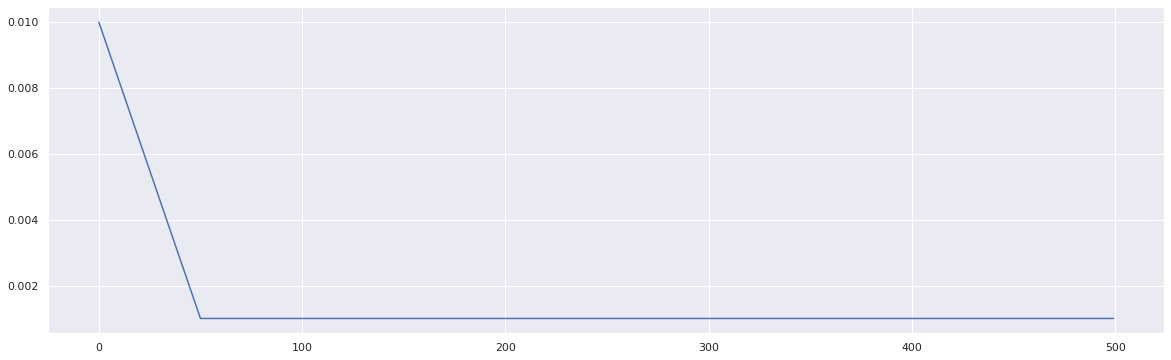

In [75]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.001
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 50
    lr_sus_ep  = 0
    lr_decay   = 0.8

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [76]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.01


In [77]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.01

1	 0.00982

2	 0.009640000000000001

3	 0.00946

4	 0.00928

5	 0.0091

6	 0.00892

7	 0.00874

8	 0.00856

9	 0.00838

10	 0.0082

11	 0.00802

12	 0.00784

13	 0.00766

14	 0.0074800000000000005

15	 0.0073

16	 0.00712

17	 0.00694

18	 0.00676

19	 0.00658

20	 0.0063999999999999994

21	 0.00622

22	 0.00604

23	 0.00586

24	 0.00568

25	 0.0055

26	 0.00532

27	 0.00514

28	 0.00496

29	 0.0047799999999999995

30	 0.0046

31	 0.0044199999999999995

32	 0.00424

33	 0.00406

34	 0.0038799999999999998

35	 0.0037

36	 0.0035199999999999997

37	 0.00334

38	 0.0031599999999999996

39	 0.00298

40	 0.0027999999999999995

41	 0.00262

42	 0.0024399999999999995

43	 0.00226

44	 0.0020800000000000003

45	 0.001899999999999999

46	 0.0017199999999999993

47	 0.0015399999999999997

48	 0.00136

49	 0.0011800000000000005

50	 0.001

51	 0.001

52	 0.001

53	 0.001

54	 0.001

55	 0.001

56	 0.001

57	 0.001

58	 0.001

59	 0.001

60	 0.001

61	 0.001

62	 0.001

63	 0.001

64	 0.0

In [78]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [79]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [80]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [81]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [82]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

# log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 


# # PretrainWeight # #
log_dir_name = "PretrainWeight"

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [83]:
# use once at the time
mk_log_dir(log_dir_name)

This log dir exist.


# Toe

In [84]:
model_name = 'EfficientNetB0'

In [162]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'


def get_best_model_name(th):
    return './' + log_dir_name + '/' + th + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

th = 'toe'
# th = 'heel'

print(get_best_model_name(th))

best_model_name = get_best_model_name(th)



best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name:', best_model_name)


# # PretrainWeight # #

def get_best_weights_name(th, FT):
    return './' + log_dir_name + '/' + th + '_' + "weights_" + FT + ".h5"

FT = 'TL'
# th = 'toe'
# # th = 'heel'

# print(get_best_model_name(th))

best_toe_weights_tl_name = get_best_weights_name(th, FT)



best_toe_weights_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_toe_weights_tl_name, 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_Weights_name:', best_toe_weights_tl_name)




./PretrainWeight/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
best_model_name: ./PretrainWeight/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
best_Weights_name: ./PretrainWeight/toe_weights_TL.h5


In [86]:
logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [87]:
callbacks = [
#     tensorboard_callback,
#     best_model_save,
    best_toe_weights_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=5), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
    PrintLRtoe()
]

In [97]:
# create keras model

# model_name = 'EfficientNetB0'

# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2

# with strategy.scope():
    
#     base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",drop_connect_rate=drop_connect_rate) #{'imagenet', None}

#     # Freeze the pretrained weights
#     base_model.trainable = False
#     print("base_model.trainable : ", base_model.trainable)

#     # Rebuild top
#     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
#     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
#     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
#     outputs = tf.keras.layers.Dense(2)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

#     # Compile new model
#     model_toe = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

#     model_toe.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)
#                       #metrics=[tf.keras.metrics.MeanSquaredError()])
#                       #metrics=[edRescal])
    
# #     loss=tf.keras.losses.MeanSquaredError()
#                     #ed_metric_2d_mean,#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                     #metrics=['mae', 'accuracy'])#!!note!! for keypoint regression should use MSE loss 01/29#
        



# # # AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False)
# # model_toe.compile(optimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
# #                 loss=ed_metric_2d_mean)#,#, ed_loss ed_metric_2d ed_metric_2d_mean            
# #                 #metrics=['mae', 'accuracy'])


# # =========================================================================================================




# Transfer learning from pre-trained weights
def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)

    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model

In [ ]:
top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 2
with strategy.scope():
    model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

In [ ]:
len(model_toe.layers)

In [ ]:
tt = 0
nt = 0
for layer in model_toe.layers:
    if layer.trainable:
        tt +=1
        print(f'{layer.name}')
    else:
        nt +=1
print(f'tt: {tt}, nt:{nt}')

In [88]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')

In [ ]:
count_model_trainOrNot_layers(model_toe)

In [ ]:
model_toe.summary()

In [ ]:
%%time

# fit the model on all data
history_toe = model_toe.fit(train_ds_pre_toe_s, 
                      verbose=1, 
                      epochs=ep_num_transf, 
                      validation_data=valid_ds_pre_toe_s, 
                      callbacks=callbacks)#, validation_split=0.1)

In [ ]:
"""train split有區域最小的問題，相同ds但最佳收斂點不同！"""
"""KFold split may have same issue."""

In [ ]:
# model_toe.summary()

In [ ]:
# tf.keras.utils.plot_model(model_toe, show_shapes=True)

In [ ]:
# show after modl.fit
model_toe.metrics_names

In [ ]:
# check metrics the model have.
history_toe.history.keys()

In [ ]:
# check the loos the model trained.
plt.figure(figsize=(10, 5))
plt.plot(history_toe.history['loss'])
plt.plot(history_toe.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_toe_tl.png', bbox_inches = 'tight')

In [ ]:
# check the loos the model trained.

# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_toe.history['loss'])
ax1.plot(history_toe.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()


# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe.history['val_loss'])
plt.savefig(f'{log_dir_name}_toe_tl_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

## Toe Fine-Tuning

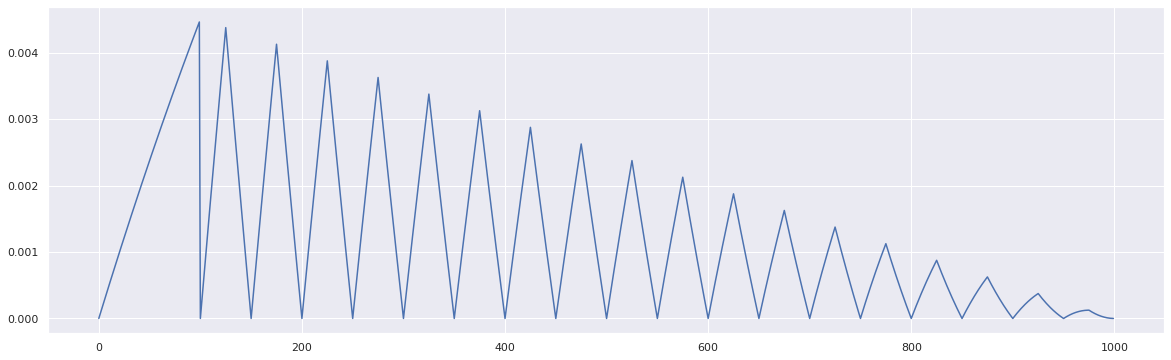

In [89]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))
    x = np.abs(iterations/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#     print(decay)
    return lr * (base_part-decay) * lr_decay # supressed the lr!


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [90]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


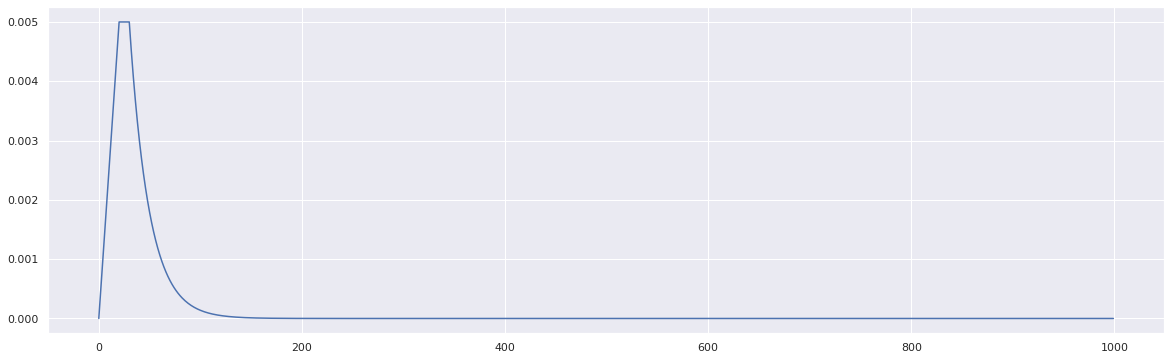

In [91]:
"""lr from kaggle leaf"""
ep_num = 1000



def lrfn2(epoch):
    
    lr_start   = 0.00000001
    # lr_max     = 0.00000125 * strategy.num_replicas_in_sync * BATCH_SIZE
    lr_max     = 0.005
    lr_min     = 0.00000001
    lr_ramp_ep = 20
    lr_sus_ep  = 10
    lr_decay   = 0.95


    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr



rng = [i for i in range(ep_num)]
y = [lrfn2(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [92]:
print('{} ~ {}'.format(min(y), max(y)))

1e-08 ~ 0.005


In [93]:
def unfreeze_model(model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.





#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True


#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166 
#

    model.trainable = True
    set_trainable = False
    for layer in model.layers:
        if layer.name == 'block5b_expand_conv': 
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [94]:
# terain a pretreained weights and reload to finetuen for check
# ./20210226-101427/toe_EfficientNetB0_bs64_w120_best_val_loss_Weights.h5

In [163]:
del model_toe

In [164]:
# Create a new model then reload the pretrained Weigths.

top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 2
# with strategy.scope():
model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

base_model.trainable :  False


In [165]:
model_toe.summary()

Model: "EfficientNetB0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 120, 120, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
normalization_7 (Normalization) (None, 120, 120, 3)  7           rescaling_7[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 121, 121, 3)  0           normalization_7[0][0]            
_____________________________________________________________________________________

In [166]:
# unfreeze for finetune the toe model  
unfreeze_model(model_toe)

In [167]:
# best_model_name = './20210226-101427/toe_EfficientNetB0_bs64_w120_best_val_loss_Weights.h5'
print('Loading ...', best_toe_weights_tl_name)
model_toe.load_weights(best_toe_weights_tl_name)

Loading ... ./PretrainWeight/toe_weights_TL.h5


In [168]:
count_model_trainOrNot_layers(model_toe)

tt: 109, nt:132, total layers:241


In [169]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=50), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp
    PrintLRtoe()
]

In [170]:
%%time

# fit the model on all data
history_toe_finetune = model_toe.fit(train_ds_pre_toe_s, 
                      verbose=1, 
                      epochs=ep_num, 
                      validation_data=valid_ds_pre_toe_s, 
                      callbacks=callbacks)#, validation_split=0.1)


[20210226-1606-38] Learning rate for epoch 1 is 4.999999987376214e-07
Epoch 1/1000
16/17 [===========================>..] - ETA: 0s - loss: 15.4061
Epoch 00001: val_loss improved from inf to 9.76524, saving model to ./PretrainWeight/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
17/17 [==============================] - 16s 967ms/step - loss: 15.4466 - val_loss: 9.7652

[20210226-1607-02] Learning rate for epoch 2 is 5.044450517743826e-05
Epoch 2/1000
17/17 [==============================] - ETA: 0s - loss: 15.4662
Epoch 00002: val_loss improved from 9.76524 to 9.71210, saving model to ./PretrainWeight/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
17/17 [==============================] - 1s 71ms/step - loss: 15.4662 - val_loss: 9.7121

[20210226-1607-05] Learning rate for epoch 3 is 0.00010028902033809572
Epoch 3/1000
17/17 [==============================] - ETA: 0s - loss: 14.7259
Epoch 00003: val_loss did not improve from 9.71210
17/17 [==============================] - 15s 890ms/step

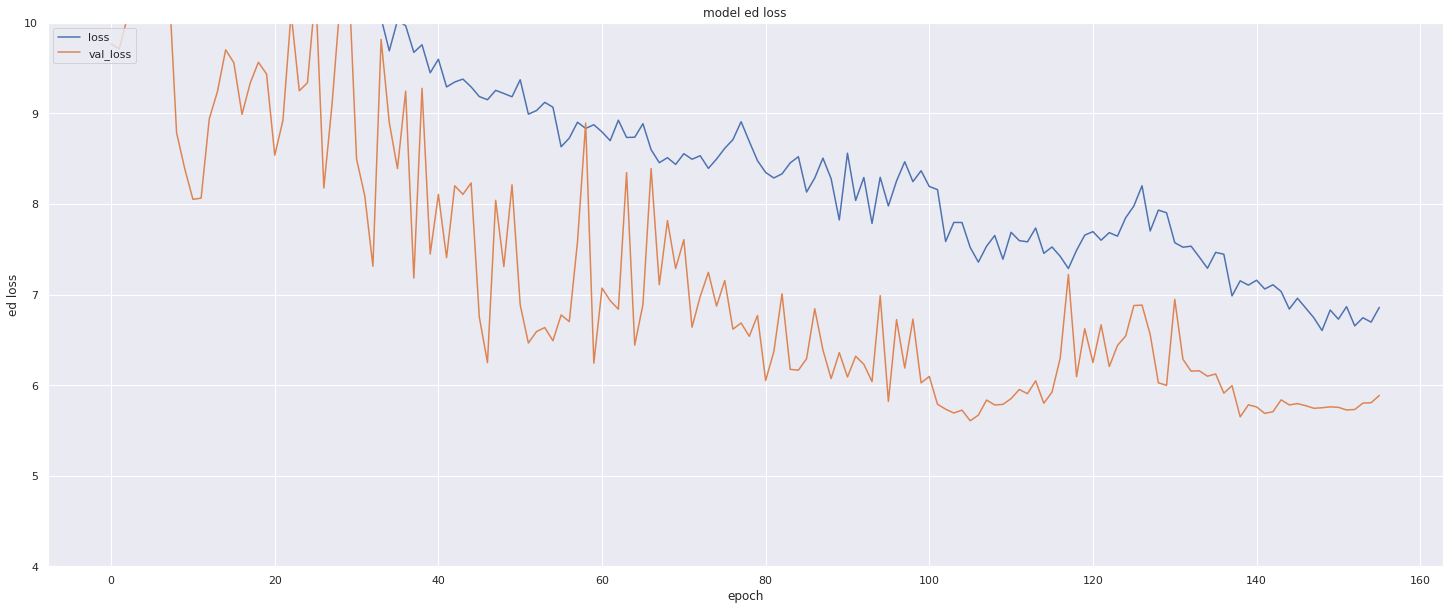

In [171]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_toe_finetune.history['loss'])
plt.plot(history_toe_finetune.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(4, 10)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_toe_ft.png', bbox_inches = 'tight')

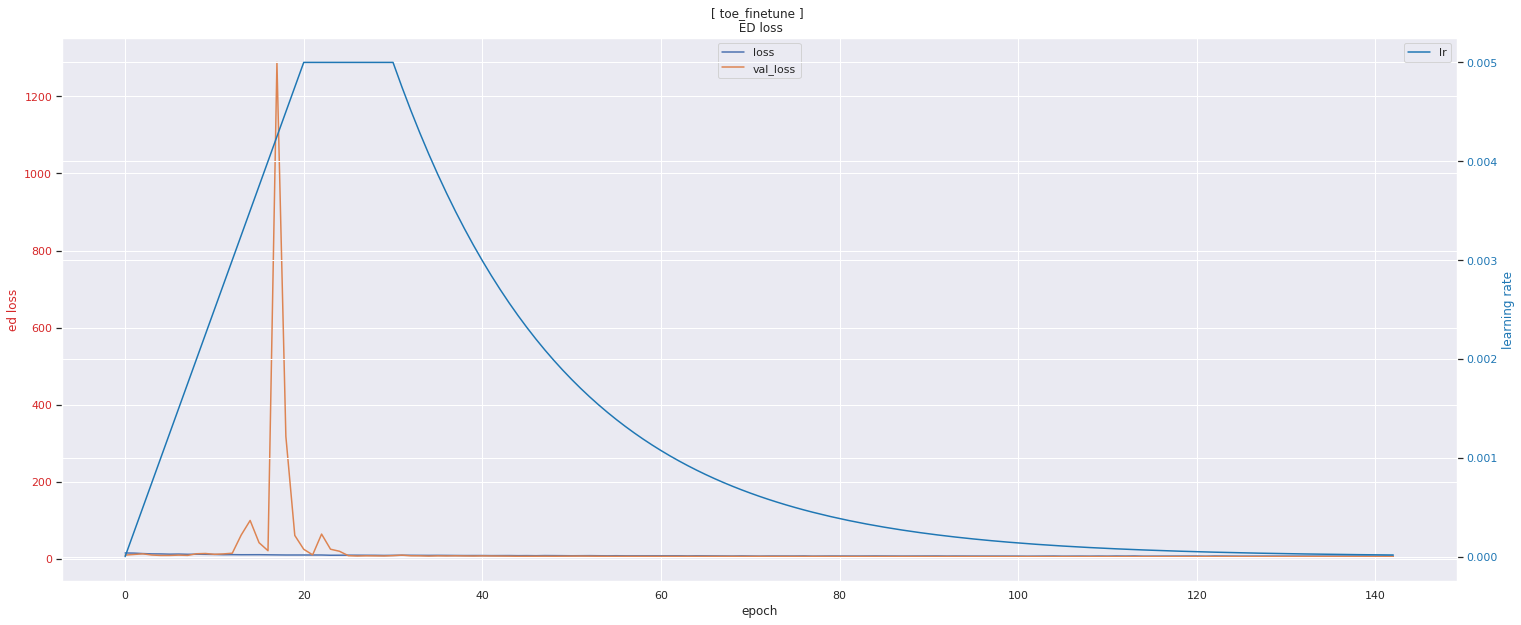

In [145]:
# check the loos the model trained.

# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ toe_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_toe_finetune.history['loss'])
ax1.plot(history_toe_finetune.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe_finetune.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe_finetune.history['val_loss'])
plt.savefig(f'{log_dir_name}_toe_ft_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [ ]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe_finetune.history['val_loss'])

vl, ep 

In [ ]:
def print_valloss(his_v_l):
     
    print(f'val_loss: {np.min(his_v_l)} at epoch {np.argmin(his_v_l)}.')
    
print_valloss(history_toe_finetune.history['val_loss'])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_toe, to_file='model_toe_conv_layer_blocks.png', show_shapes=True)
from IPython.display import Image
Image(filename='model_toe_conv_layer_blocks.png') 

## Check the mean-Euclidean Distance of test data

may modify the ed-loss function

In [ ]:
# mean ed-loss == mean ed of test data.
model_toe.evaluate(valid_ds_pre_toe_s)

# Heel 

### Transfer

In [ ]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 0
    lr_sus_ep  = 0
    lr_decay   = 0.8

    if lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [ ]:
print('{} ~ {}'.format(min(y), max(y)))

In [ ]:
"""

"""
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, 
#                                                           factor=0.5, 
#                                                           patience=15, 
#                                                           verbose=1, 
#                                                           mode='auto', 
#                                                           #min_delta=0.0001, 
#                                                           cooldown=5, 
#                                                           #min_lr=1e-12
#                                                          )

In [ ]:
def get_best_model_name(th):
    return './' + log_dir_name + '/' + th + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
th = 'heel'

print(get_best_model_name(th))

best_model_name = get_best_model_name(th)


best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name:', best_model_name)

In [ ]:
logdir = log_dir_name + "/logs/heel/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=10), #patience=step_size ot ep_num
    tf.keras.callbacks.LearningRateScheduler(lrdump),#,clr2_heel  lrfn2_heel decay or lrfn or lrfn2. clr
#     lr_reduceonplateau,
    PrintLRheel()
]

In [ ]:
# create Heel-tf model
top_dropout_rate = 0.4 #less dp rate, say 0.1, train_loss will lower than val_loss
drop_connect_rate = 0.4 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 2
with strategy.scope():
    model_heel = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

In [ ]:
count_model_trainOrNot_layers(model_heel)

In [ ]:
%%time

# fit the model on all data
history_heel = model_heel.fit(train_ds_pre_heel_s, 
                      verbose=1, 
                      epochs=ep_num_transf, 
                      validation_data=valid_ds_pre_heel_s, 
                      callbacks=callbacks)

In [ ]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_heel.history['loss'])
plt.plot(history_heel.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(3, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_heel_tl', bbox_inches = 'tight')

In [ ]:
# check the loos the model trained.


# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_heel.history['loss'])
ax1.plot(history_heel.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel.history['val_loss'])
plt.savefig(f'{log_dir_name}_heel_tl_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [ ]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel.history['val_loss'])

vl, ep

## Heel Fine-Tuning

In [ ]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7
    
#     step_size = 25 # currently best for foot pp
#     max_lr = 0.01 # currently best for foot pp
#     base_lr = 1e-8 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))# 1~20 range.
    x = np.abs(iterations/step_size - 2*cycle + 1) # 1~0,repeat 20 cycle.
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))

    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = base_lr + (((max_lr - base_lr) / lr_ramp_ep) * epoch)
    
#     # decay
#     if epoch > lr_ramp_ep:
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#         lr = lr * (base_part-decay)

    return lr * (base_part-decay) * lr_decay # supressed the lr! in fact, it will reduce new lr to 1/2 ratio.


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [ ]:
# 4.999999999999993e-08 ~ 0.00891990901   # original lr with epoch decay.
# 2.4999999999999966e-08 ~ 0.004459954505 # supressed the lr!

In [ ]:
print('{} ~ {}'.format(min(y), max(y)))

In [ ]:
# unfreeze for finetune the toe model  
unfreeze_model(model_heel)

In [ ]:
count_model_trainOrNot_layers(model_heel)

In [ ]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=100), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr
    PrintLRheel()
]

In [ ]:
%%time

# fit the model on all data
history_heel_finetune = model_heel.fit(train_ds_pre_heel_s, 
                      verbose=1, 
                      epochs=ep_num, 
                      validation_data=valid_ds_pre_heel_s, 
                      callbacks=callbacks)

In [ ]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_heel_finetune.history['loss'])
plt.plot(history_heel_finetune.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(3, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_heel_ft.png', bbox_inches = 'tight')

In [ ]:
# check the loos the model trained.


# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color), ax1.set_ylim(3, 50)

ax1.plot(history_heel_finetune.history['loss'])
ax1.plot(history_heel_finetune.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel_finetune.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel_finetune.history['val_loss'])
plt.savefig(f'{log_dir_name}_heel_ft_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [ ]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel_finetune.history['val_loss'])

In [ ]:
vl, ep 

In [ ]:
def print_valloss(his_v_l):
     
    print(f'val_loss: {np.min(his_v_l)} at epoch {np.argmin(his_v_l)}.')
    
print_valloss(history_heel_finetune.history['val_loss'])

In [ ]:
# mean ed-loss == mean ed of test data.
model_heel.evaluate(valid_ds_pre_heel_s)

## Show predictions

In [ ]:
# %%time
# # inference all val_ds
# predictions = model.predict(valid_ds_pre_toe_s)

In [ ]:
# predictions.shape

In [ ]:
# predictions[:5]

In [ ]:
# %%time

# # inference bs by bs of val_ds #model.predict()#一次做完即可不用分batch
# image_batch, label_batch = valid_ds_pre_heel_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)

In [ ]:
# image_batch.shape

In [ ]:
# pred.shape

In [ ]:
# pred[:5]

In [ ]:
# label_batch[:5]

In [ ]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [ ]:
# neg[:5]

In [ ]:
# neg.mean()#所有x,y平均

In [ ]:
# neg.mean(axis=0)#所有x 所有y個別平均

In [ ]:
# neg.mean(axis=1)#左x右y相加的平均

In [ ]:
# np.median(neg)#中位數

In [ ]:
# neg.min(axis=0)

In [ ]:
# neg.max(axis=0)

In [ ]:
# model.metrics_names

## show pp pred

* we can switch toe/hell by comment it

### Baseline Simple2D model

In [ ]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# # it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [ ]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# # image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# # pred = model_toe.predict_on_batch(image_batch) #predictions
# pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=4)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=4)

### EFN Toe

In [ ]:
it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [ ]:
%%time

# image_batch, label_batch = next(valid_ds_pre_toe_s)

image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# image_batch, label_batch = next(it_valid_ds_pre_heel_s)


pred = model_toe.predict_on_batch(image_batch) #predictions
# pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

plt.figure(figsize=(20, 20))
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(image_batch[i])
    plt.title(label_batch[i].numpy())
    plt.axis("off")
    
    # note: y_offset_toe for ds image
    
    #ground truth
    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

    #pred
    plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [ ]:
#test_ds一次做完即可不用分batch
neg = label_batch - pred
neg[:5]

In [ ]:
np.abs(neg)[:5]

In [ ]:
neg_abs = np.abs(neg)
neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2D

In [ ]:
# y_pred = neg_abs.mean(axis=0)
ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

### EFN Heel

In [ ]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [ ]:
%%time

# image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
image_batch, label_batch = next(it_valid_ds_pre_heel_s)


pred = model_heel.predict_on_batch(image_batch) #predictions
# pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

plt.figure(figsize=(20, 20))
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(image_batch[i])
    plt.title(label_batch[i].numpy())
    plt.axis("off")
    
    # note: y_offset_toe for ds image
    
    #ground truth
    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

    #pred
    plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [ ]:
pred[:5]

In [ ]:
label_batch[:5]

In [ ]:
#test_ds一次做完即可不用分batch
neg = label_batch - pred
neg[:10]

In [ ]:
np.abs(neg)[:10]

In [ ]:
neg_abs = np.abs(neg)
neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2d

In [ ]:
# y_pred = neg_abs.mean(axis=0)
ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

# Merg Toe/Heel model and predict the Test data at once

### Create TEST DS

In [ ]:
ts = 'test_submission.csv'
df_ts = pd.read_csv(ts)
df_ts.head(5)

In [ ]:
df_ts['images']

In [ ]:
# from dataframe
list_ds_test = tf.data.Dataset.from_tensor_slices(df_ts['images'])


In [ ]:
len(list_ds_test)#.shape() #take(1)

In [ ]:
# check The type specification of an element of this dataset.
list_ds_test.element_spec

In [ ]:
for f in list_ds_test.take(5):
    print(f'take test sample: {f}')

### TEST DS: Process TEST path to image tensor

In [ ]:
## TEST-DS: re-used from train/val-ds

im_test = 'test_images/'

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe_test(img)
    return img, file_name

#
# map list to ds, Heel part.
#

def decode_crop_png_heel_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel_test(img)
    return img, file_name


#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [ ]:
# TEST Toe ds
test_ds_map_toe = list_ds_test.map(process_path_toe_test, num_parallel_calls=AUTOTUNE)

# TEST Heel ds
test_ds_map_heel = list_ds_test.map(process_path_heel_test, num_parallel_calls=AUTOTUNE)

In [ ]:
for img, file_name in test_ds_map_toe.take(5):
    print(f'take sample: {img.shape} {file_name}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

### prepare TEST_ds_pre

In [ ]:
def configure_for_performance_cache_test(ds, cache=True):

    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
#     if augment:
# #         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
# #         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(1000)# 1k for foot test images #MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    return ds


In [ ]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# TEST Toe ds_pre
test_ds_pre_toe = configure_for_performance_cache_test(test_ds_map_toe)

# TEST Heel ds_pre
test_ds_pre_heel = configure_for_performance_cache_test(test_ds_map_heel)

## Predict test (abandon)

### Toe model

In [ ]:
# model_toe

In [ ]:
# %%time
# # inference all test_ds once
# predictions_toe = model_toe.predict(test_ds_pre_toe)
# predictions_toe.shape

In [ ]:
# predictions_toe

### Offset Toe

In [ ]:
# predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe
# predictions_toe

### Heel model

In [ ]:
# %%time
# # inference all test_ds once
# predictions_heel = model_heel.predict(test_ds_pre_heel)
# predictions_heel.shape

In [ ]:
# predictions_heel

### Offset Heel

In [ ]:
# predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel
# predictions_heel

### Merge toe/hell pred

In [ ]:
# predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
# predictions_th.shape

In [ ]:
# predictions_th.shape

In [ ]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [ ]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [ ]:
# predictions_merge.take(0)

In [ ]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [ ]:
# df_submission.head(5)

In [ ]:
# df_submission.to_csv('submission.csv', index=False)

# Load Best-model

In [ ]:
# if models are in last time frame
best_model_toe_name = get_best_model_name('toe')
best_model_heel_name = get_best_model_name('heel')

# # if toe/heel are in different time frame
# best_model_toe_name = '20210118-212454/toe_EfficientNetB0_bs64_w120_best_val_loss.h5'#6.3318 @e393
# best_model_heel_name = '20210122-084854/heel_EfficientNetB0_bs64_w120_best_val_loss.h5'#3.27979@152




print(best_model_toe_name)
print(best_model_heel_name)
# log_dir_name + '/' + 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'

best_model_toe = tf.keras.models.load_model(best_model_toe_name,compile=False)
best_model_heel = tf.keras.models.load_model(best_model_heel_name,compile=False)

### compile the model separately afterwards. to load model with custom loss function

* https://github.com/tensorflow/tensorflow/issues/32348

In [ ]:
best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])
best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])

# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

    

In [ ]:
%%time
# inference all test_ds once
predictions_toe = best_model_toe.predict(test_ds_pre_toe)
predictions_toe.shape

### Offset Toe

In [ ]:
predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe

# for [0,1]
# predictions_toe[:,0] = predictions_toe[:,0]*120
# predictions_toe[:,1] = predictions_toe[:,1]*120 + y_offset_toe

# # for [-1,1]
# # for re-scale back xy 
# # return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# # return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] 
# predictions_toe[:,0] = (predictions_toe[:,0]*60)+60
# predictions_toe[:,1] = (predictions_toe[:,1]*60)+60 + y_offset_toe

predictions_toe

In [ ]:
%%time
# inference all test_ds once
predictions_heel = best_model_heel.predict(test_ds_pre_heel)
predictions_heel.shape

### Offset Heel

In [ ]:
predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel

# for [0,1]
# predictions_heel[:,0] = predictions_heel[:,0]*120
# predictions_heel[:,1] = predictions_heel[:,1]*120 + y_offset_heel

# # for [-1,1]
# predictions_heel[:,0] = (predictions_heel[:,0]*60)+60
# predictions_heel[:,1] = (predictions_heel[:,1]*60)+60 + y_offset_heel

predictions_heel

### Merge toe/hell pred

In [ ]:
predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
predictions_th.shape

In [ ]:
images_name = np.expand_dims(df_ts['images'], axis=1)
images_name.shape

In [ ]:
predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
predictions_merge.shape

In [ ]:
df_submission = pd.DataFrame(predictions_merge)
df_submission.columns = ['images','x1','y1','x2','y2']

In [ ]:
submi_name = '0000_ft_' + log_dir_name +'.csv'
# submi_name = 'Bth_clr3_2690_XYnorm[0-1]_' + log_dir_name +'.csv'
df_submission.to_csv(submi_name, index=False)
print('Save {} as submission CSV.'.format(submi_name))

In [ ]:
#Bth_clr3_2690_ed_findtune_20210202-141718.csv

#toe.9.9/heel.4.4 109 trainable LB:9.3411759 比heel保持top-20略高0.04 (9.3084957)

In [ ]:
df_submission.head()

In [ ]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl, _ = get_valloss(history_toe_finetune.history['val_loss'])
h_vl, _ = get_valloss(history_heel_finetune.history['val_loss'])

print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

In [ ]:
#

## save model

In [ ]:

# best_model_name = './cop_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_e' + str(ep_num) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_.h5'
# # model.save(best_model_name)
# print("Save model: ", best_model_name)

## Reference

multi output model:
https://navoshta.com/end-to-end-deep-learning/

